In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import glob 
import re
from datetime import datetime,date
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

import xgboost as xgb

In [3]:
#conda install -y -c conda-forge xgboost

## Data Loading and Processing

In [98]:
l_201912=pd.read_csv('/Users/ruoqigao/Desktop/Springboard/capstone 1 data/l_201912.csv')

In [99]:
l_201912['avail_30_bucket']=[0 if n in np.arange(0,6) else 1 if n in np.arange(6,25) else 2 for 
                             n in l_201912['availability_30']]

In [100]:
#remove columns
rm_list=['Year','Month','has_availability','availability_30', 'availability_365','availability_60', 
         'availability_90','price','cleaning_fee','extra_people','id','host_since','neighbourhood_cleansed','avail_30_bucket']
col_list=list(l_201912.columns.values)
x_list = [e for e in col_list if e not in rm_list]

In [101]:
X=l_201912[x_list]
y=l_201912['price']
y_log=np.log(y)
y_3=l_201912['price']*3+l_201912['cleaning_fee']
y_3_log=np.log(y_3)

In [102]:
#create dummies for categorical variables
object_cols=['bed_type','host_identity_verified','host_info','host_is_superhost',
             'instant_bookable','is_business_travel_ready','is_location_exact','property_type',
             'require_guest_phone_verification','require_guest_profile_picture','room_type']
X[object_cols]=X[object_cols].apply(lambda x: x.astype('category'),axis=0)
X=pd.get_dummies(X,drop_first=True)

In [103]:
#Different Scalers:

#1. scale: scaled data has 0 mean and unit variance
#2. StandardScaler(): compute the mean and standard deviation on a training set so as to be able to 
#   later reapply the same transformation on the testing set.
#eg. scaler = preprocessing.StandardScaler().fit(X_train)
#    scaler.transform(X_test)
#3. MinMaxScaler(): The estimator scales and translates each feature individually such that it is in the given 
#   range on the training set, e.g. between zero and one. The motivation to use this scaling include robustness 
#   to very small standard deviations of features and preserving zero entries in sparse data.
#4. MaxAbsScaler(): scales in a way that the training data lies within the range [-1, 1] 
#   by dividing through the largest maximum value in each feature. It is meant for data that is already 
#   centered at zero or sparse data.

In [104]:
#remove highly correlated features for the linear models:
X_linear=X.drop(['bedrooms','bathrooms','review_scores_accuracy','review_scores_checkin','review_scores_cleanliness',
                 'review_scores_communication','review_scores_location','review_scores_value',
                 'number_of_reviews','review_sincelast'],axis=1)

In [105]:
X.shape

(33701, 196)

In [106]:
X.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds',
       'calculated_host_listings_count', 'guests_included', 'host_id',
       'latitude', 'longitude', 'maximum_nights',
       ...
       'property_type_Train', 'property_type_Treehouse',
       'property_type_Vacation home', 'property_type_Villa',
       'property_type_Yurt', 'require_guest_phone_verification_t',
       'require_guest_profile_picture_t', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object', length=196)

## Fit Regression Models

### Linear Models: Elastic Net, LASSO and Ridge Regression

In [13]:
#Elastic Net
#preprocessor only performs on X
def elastic_net(X,y):
    
    steps=[('scaler', StandardScaler()),('elasticnet', ElasticNet())]
    pipeline = Pipeline(steps)
    parameters = {'elasticnet__l1_ratio':np.linspace(0,1,30)}
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    en_cv = GridSearchCV(pipeline,parameters,cv=3)
    en_cv.fit(X_train,y_train)
    best_params=en_cv.best_params_.get('elasticnet__l1_ratio')
    r2_train=en_cv.score(X_train,y_train)
    r2_test=en_cv.score(X_test,y_test)
    y_pred=en_cv.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return best_params, r2_train, r2_test, mse

In [14]:
#price as y
en_best_params_1,en_r2_train_1,en_r2_test_1,mse_1=elastic_net(X_linear,y)
print(en_best_params_1,en_r2_train_1,en_r2_test_1,mse_1)

1.0 0.5072186707479132 0.5042369133771333 23493.405253870136


In [15]:
#log(price) as y
en_best_params_2,en_r2_train_2,en_r2_test_2,mse_2=elastic_net(X_linear,y_log)
print(en_best_params_2,en_r2_train_2,en_r2_test_2,mse_2)

0.0 0.6290589215063105 0.6410464872326016 0.2196742097241839


In [16]:
#3 day total price as y
en_best_params_3,en_r2_train_3,en_r2_test_3,mse_3=elastic_net(X_linear,y_3)
print(en_best_params_3,en_r2_train_3,en_r2_test_3,mse_3)

1.0 0.5424870966522614 0.5386492196205945 235717.76806945144


In [17]:
#log 3 day total price as y
y_3_log=np.log(y_3)
en_best_params_4,en_r2_train_4,en_r2_test_4,mse_4=elastic_net(X_linear,y_3_log)
print(en_best_params_4,en_r2_train_4,en_r2_test_4,mse_4)

0.0 0.6546344518826546 0.6666617878783054 0.20170206344916494


In [18]:
def top_features(model,best_param,X,y):

    if model=='elasticnet':
        lm=ElasticNet(l1_ratio=best_param)
    elif model=='lasso':
        lm=Lasso(alpha=best_param)
    elif model=='ridge':
        lm=Ridge(alpha=best_param)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    coefs=list(lm.fit(X_train,y_train).coef_)
    name=list(X.columns)
    en_pairs=dict(zip(name,coefs))
    df_pairs=pd.DataFrame.from_dict({k: v for k, v in sorted(en_pairs.items(), key=lambda item: item[1])},orient='index')
    df_head=df_pairs.head(10)
    df_tail=df_pairs.tail(10)
    dfs=[df_head,df_tail]
    return pd.concat(dfs).sort_values(by=0)

In [19]:
en1=top_features('elasticnet',en_best_params_1,X_linear,y)
print(en1)

                                      0
longitude                    -26.662789
reviews_per_month            -24.286707
room_type_Private room       -22.043037
property_type_Apartment      -16.504207
room_type_Shared room        -16.408794
review_sincefirst            -11.676468
latitude                      -7.806050
Hot water                     -6.459753
room_type_Hotel room          -6.406799
instant_bookable_t            -5.830796
property_type_Boutique hotel  10.783435
Downtown                      10.896375
Beverly Grove                 11.679848
Venice                        13.224115
property_type_House           17.059511
Beverly Crest                 21.557323
Malibu                        26.491109
Hollywood Hills West          30.930878
property_type_Villa           33.866456
accommodates                  83.492052


In [20]:
en2=top_features('elasticnet',en_best_params_2,X_linear,y_log)
print(en2)

                                 0
room_type_Private room   -0.121033
room_type_Shared room    -0.090376
longitude                -0.065823
other area               -0.039721
reviews_per_month        -0.034778
Rowland Heights          -0.028309
property_type_Hostel     -0.024962
property_type_Apartment  -0.023639
Hot water                -0.023454
number_of_reviews_ltm    -0.022265
Avalon                    0.026934
property_type_Villa       0.030220
Free parking on premises  0.036338
Venice                    0.038172
Malibu                    0.039123
Hollywood Hills West      0.042284
TV                        0.047266
guests_included           0.070253
beds                      0.074414
accommodates              0.141133


In [21]:
en3=top_features('elasticnet',en_best_params_3,X_linear,y_3)
print(en3)

                                         0
property_type_Apartment        -120.137920
reviews_per_month               -90.349469
room_type_Private room          -85.357330
longitude                       -80.254029
room_type_Shared room           -63.484253
review_sincefirst               -44.858854
latitude                        -38.227935
property_type_Condominium       -37.204458
property_type_Guesthouse        -36.699821
room_type_Hotel room            -30.975958
calculated_host_listings_count   32.895784
Downtown                         34.146944
Hollywood Hills                  34.954920
Beverly Grove                    42.183706
Venice                           49.118648
Beverly Crest                    72.771481
Malibu                           87.919596
property_type_Villa              94.185108
Hollywood Hills West            103.396802
accommodates                    271.547348


In [22]:
en4=top_features('elasticnet',en_best_params_4,X_linear,y_3_log)
print(en4)

                                 0
room_type_Private room   -0.126902
room_type_Shared room    -0.093542
longitude                -0.065972
reviews_per_month        -0.039663
other area               -0.039441
Rowland Heights          -0.029831
property_type_Hostel     -0.026775
number_of_reviews_ltm    -0.025097
room_type_Hotel room     -0.023568
Hot water                -0.022081
Avalon                    0.026302
property_type_Villa       0.027715
Free parking on premises  0.036353
Malibu                    0.036751
Venice                    0.037374
Hollywood Hills West      0.040809
TV                        0.050071
guests_included           0.070243
beds                      0.073245
accommodates              0.139816


In [31]:
def lasso(X,y):
    steps=[('scaler', StandardScaler()),('lasso', Lasso())]
    pipeline = Pipeline(steps)
    parameters = {'lasso__alpha':np.linspace(0,1,30)}
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    lasso_cv = GridSearchCV(pipeline,parameters,cv=3)
    lasso_cv.fit(X_train,y_train)
    best_params=lasso_cv.best_params_.get('lasso__alpha')
    r2 = lasso_cv.score(X_test, y_test)
    
    return best_params, r2

In [32]:
ls_best_params,ls_r2=lasso(X_linear,y_3_log)
print(ls_best_params,ls_r2)

0.0 0.746681520478901


In [33]:
ls1=top_features('lasso',ls_best_params,X_linear,y_3_log)
print(ls1)

                                  0
property_type_Apartment   -0.322766
room_type_Private room    -0.249020
property_type_House       -0.219520
room_type_Shared room     -0.199426
property_type_Guesthouse  -0.148948
property_type_Condominium -0.129825
property_type_Guest suite -0.128031
reviews_per_month         -0.115692
longitude                 -0.096160
property_type_Bungalow    -0.094116
Beverly Hills              0.039395
Beverly Grove              0.040310
Hollywood Hills            0.042020
guests_included            0.042092
Downtown                   0.047254
Santa Monica               0.047575
Malibu                     0.058535
Hollywood Hills West       0.071999
Venice                     0.073647
accommodates               0.271452


In [27]:
def ridge(X,y):
    steps=[('scaler', StandardScaler()),('ridge', Ridge())]
    pipeline = Pipeline(steps)
    parameters = {'ridge__alpha':np.linspace(0, 1, 30)}
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    rg_cv = GridSearchCV(pipeline,parameters,cv=3)
    rg_cv.fit(X_train,y_train)
    best_params=rg_cv.best_params_.get('ridge__alpha')
    r2 = rg_cv.score(X_test, y_test)
    
    return best_params, r2

In [34]:
rg_best_params,rg_r2=ridge(X_linear,y_3_log)
print(rg_best_params,rg_r2)

0.034482758620689655 0.7466820357521968


In [35]:
rg1=top_features('ridge',rg_best_params,X_linear,y_3_log)
print(rg1)

                                  0
property_type_Apartment   -0.322705
room_type_Private room    -0.249020
property_type_House       -0.219459
room_type_Shared room     -0.199425
property_type_Guesthouse  -0.148917
property_type_Condominium -0.129795
property_type_Guest suite -0.128006
reviews_per_month         -0.115691
longitude                 -0.096159
property_type_Bungalow    -0.094094
Dryer                      0.033874
Beverly Crest              0.034250
Downtown                   0.035671
TV                         0.036529
Santa Monica               0.036811
guests_included            0.042092
Malibu                     0.053088
Venice                     0.059677
Hollywood Hills West       0.064347
accommodates               0.271451


In [ ]:
#algorithms that rely on rules-tree based algorithms do not require scaling
#algorithms that rely on distribution of variables do not require scaling-Naive Bayes

### Non-Linear Models: Support Vector Regressor, Random Forest Regressor and Gradient Boosting Regressor

In [41]:
#SVR baseline model fit
steps=[('scaler', StandardScaler()),('svr', SVR())] 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
pipeline = Pipeline(steps)
sv= pipeline.fit(X_train,y_train)
r2_sv=sv.score(X_test,y_test)
print(r2_sv)

0.22461454890615884


In [42]:
#also try linear kernel to see if the result improves
steps=[('scaler', StandardScaler()),('svr', SVR(kernel='linear'))] 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
pipeline = Pipeline(steps)
sv= pipeline.fit(X_train,y_train)
r2_sv=sv.score(X_test,y_test)
print(r2_sv)

0.49577896563890367


In [43]:
#max_depth refers to the maximum depth of the tree and n_estimators, the number of trees in the forest
#max depth: square root of the features
def random_forest(X,y):
    gsc = GridSearchCV(estimator=RandomForestRegressor(),
                       param_grid={'max_depth': np.arange(7,16),'n_estimators': [100,150]},
                       cv=3, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    grid_result = gsc.fit(X_train, y_train)
    best_depth = grid_result.best_params_.get('max_depth')
    best_estimators=grid_result.best_params_.get('n_estimators')
    
    return best_depth,best_estimators

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
rf_best_depth_1,rf_best_estimators_1=random_forest(X,y)
rf1=RandomForestRegressor(max_depth=rf_best_depth_1,n_estimators=rf_best_estimators_1)
rf1.fit(X_train,y_train)
print(rf_best_depth_1,rf_best_estimators_1,rf1.score(X_test,y_test))

15 100 0.7122919518580237


In [45]:
rf_best_depth_2,rf_best_estimators_2=random_forest(X,y_log)
rf2=RandomForestRegressor(max_depth=rf_best_depth_2,n_estimators=rf_best_estimators_2)
rf2.fit(X_train,y_train)
print(rf_best_depth_2,rf_best_estimators_2,rf2.score(X_test,y_test))

15 150 0.7135656977905483


In [46]:
rf_best_depth_3,rf_best_estimators_3=random_forest(X,y_3)
rf3=RandomForestRegressor(max_depth=rf_best_depth_3,n_estimators=rf_best_estimators_3)
rf3.fit(X_train,y_train)
print(rf_best_depth_3,rf_best_estimators_3,rf3.score(X_test,y_test))

15 150 0.7147511968858049


In [47]:
rf_best_depth_4,rf_best_estimators_4=random_forest(X,y_3_log)
rf4=RandomForestRegressor(max_depth=rf_best_depth_4,n_estimators=rf_best_estimators_4)
rf4.fit(X_train,y_train)
print(rf_best_depth_4,rf_best_estimators_4,rf4.score(X_test,y_test))

15 150 0.7119208696187771


In [48]:
def top_20_features(rf):
    feature_importance = rf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    name=list(X.columns)
    rf_pairs=dict(zip(name,feature_importance))
    rf_pairs=pd.DataFrame.from_dict({k: v for k, v in sorted(rf_pairs.items(), key=lambda item: item[1])},orient='index')
    rf_top=rf_pairs.tail(20)
    #rf_top=rf_top.iloc[::-1]
    
    plt.figure(figsize=(10,10))
    plt.barh(list(rf_top.index),rf_top.iloc[:,0], align='center')
    plt.ylabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    

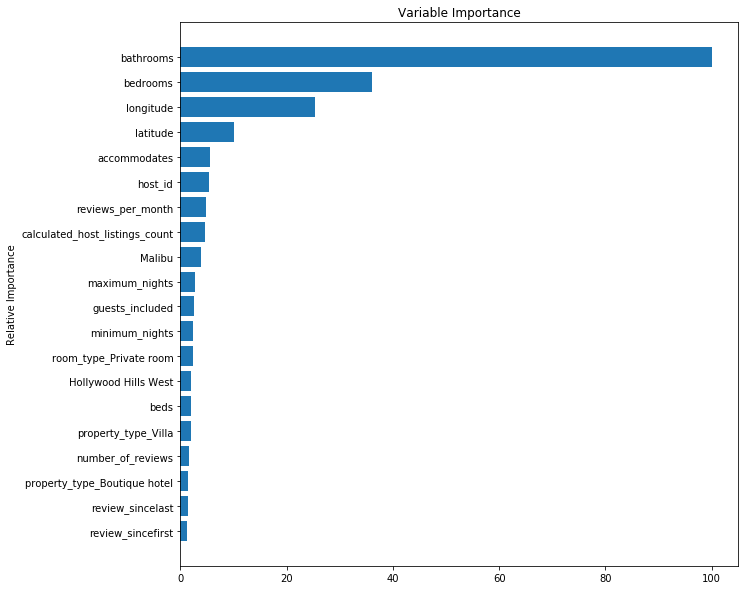

In [49]:
top_20_features(rf1)

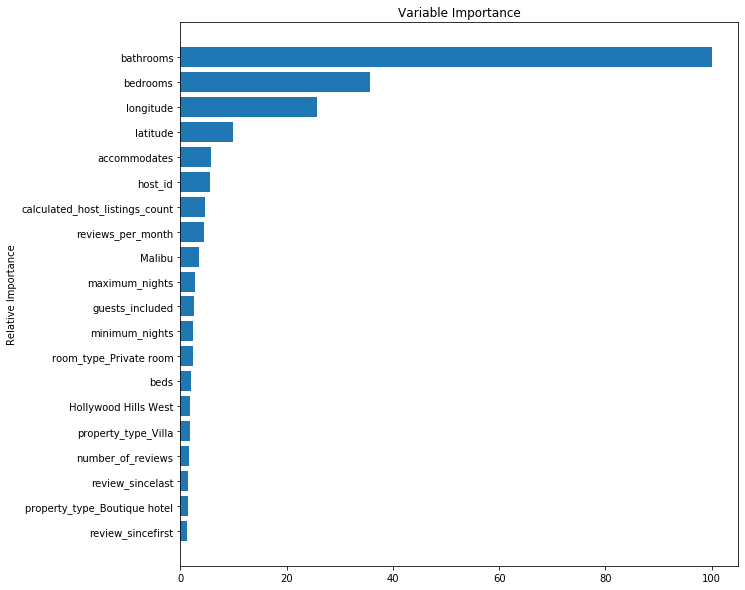

In [50]:
top_20_features(rf2)

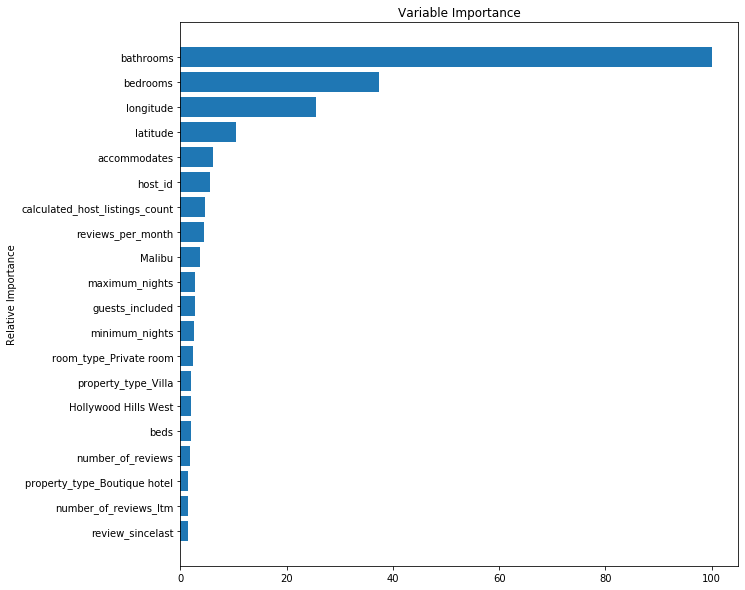

In [51]:
top_20_features(rf3)

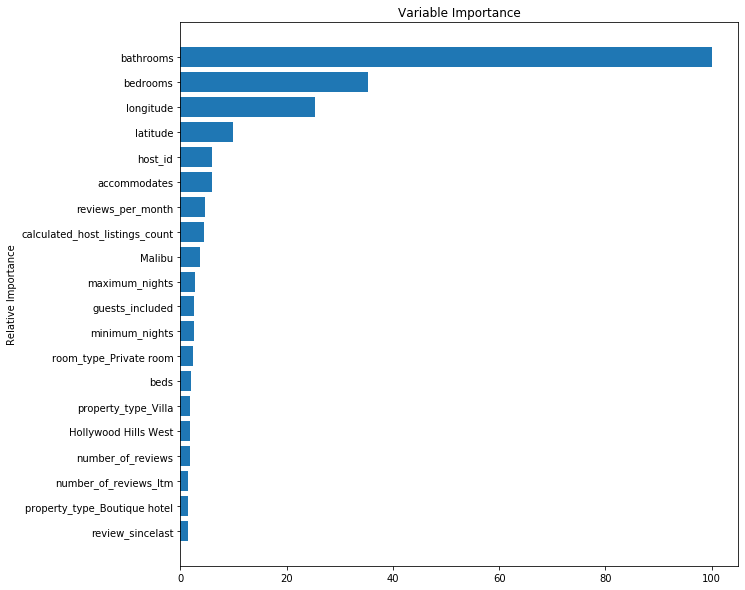

In [52]:
top_20_features(rf4)

In [53]:
#Gradient boosting
def gradient_boosting(X,y):
    gsc = GridSearchCV(estimator=GradientBoostingRegressor(loss='ls'),
                       param_grid={'n_estimators':[100,200],'max_depth': [3,4,5],'min_samples_split':[2],
                                   'learning_rate':[0.1,0.05,0.01]},cv=3)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    gb = gsc.fit(X_train, y_train)
    gb_r2 = gb.score(X_test,y_test)
    best_depth = gb.best_params_.get('max_depth')
    best_estimators=gb.best_params_.get('n_estimators')
    learning_rate=gb.best_params_.get('learning_rate')
    
    return best_depth, best_estimators, learning_rate, gb_r2

In [54]:
#found that the best parameters for 4 dependent variables are n_estimators=200,max_depth=5 and learning_rate=0.1
params = {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'ls'}

In [55]:
#deviance plot
def deviance_plot(grad):
    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(grad.staged_predict(X_test)):
        test_score[i] = grad.loss_(y_test, y_pred)

    plt.figure(figsize=(10, 10))
    plt.title('Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, grad.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')

In [56]:
#gb_best_depth_1,gb_best_estimators_1,gb_learning_rate_1,gb_r2_1=gradient_boosting(X,y)
grad_1=GradientBoostingRegressor(**params)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
grad_1.fit(X_train, y_train)
gb_r2_1 = grad_1.score(X_test,y_test)
print(gb_r2_1)

0.7224835972592889


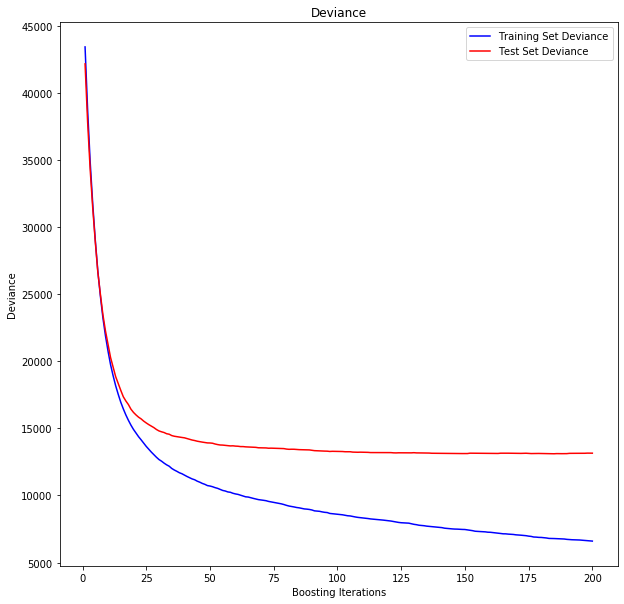

In [57]:
deviance_plot(grad_1)

In [58]:
grad_2=GradientBoostingRegressor(**params)
X_train, X_test, y_train, y_test = train_test_split(X,y_log,test_size=0.3,random_state=42)
grad_2.fit(X_train, y_train)
gb_r2_2 = grad_2.score(X_test,y_test)
print(gb_r2_2)

0.8083869504840466


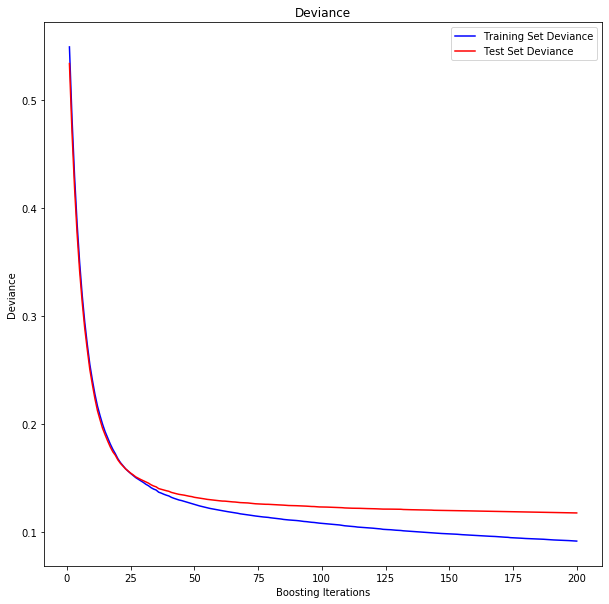

In [59]:
deviance_plot(grad_2)

In [60]:
grad_3=GradientBoostingRegressor(**params)
X_train, X_test, y_train, y_test = train_test_split(X,y_3,test_size=0.3,random_state=42)
grad_3.fit(X_train, y_train)
gb_r2_3 = grad_3.score(X_test,y_test)
print(gb_r2_3)

0.7548390778728131


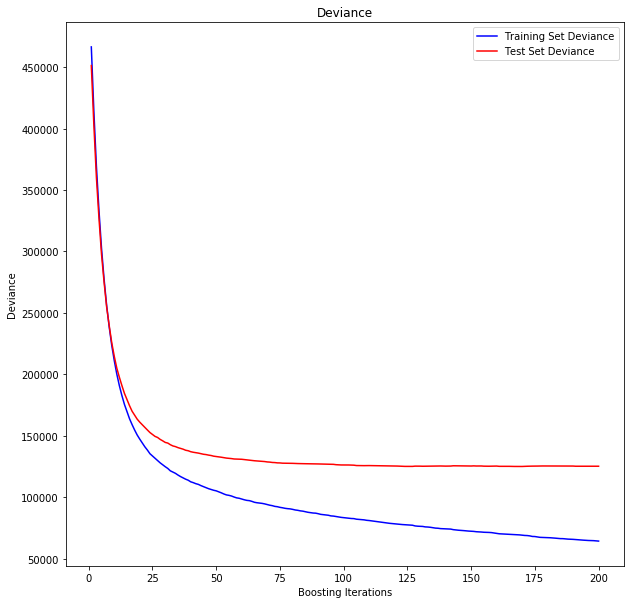

In [61]:
deviance_plot(grad_3)

In [62]:
grad_4=GradientBoostingRegressor(**params)
X_train, X_test, y_train, y_test = train_test_split(X,y_3_log,test_size=0.3,random_state=42)
grad_4.fit(X_train, y_train)
gb_r2_4 = grad_4.score(X_test,y_test)
print(gb_r2_4)

0.8307478119123485


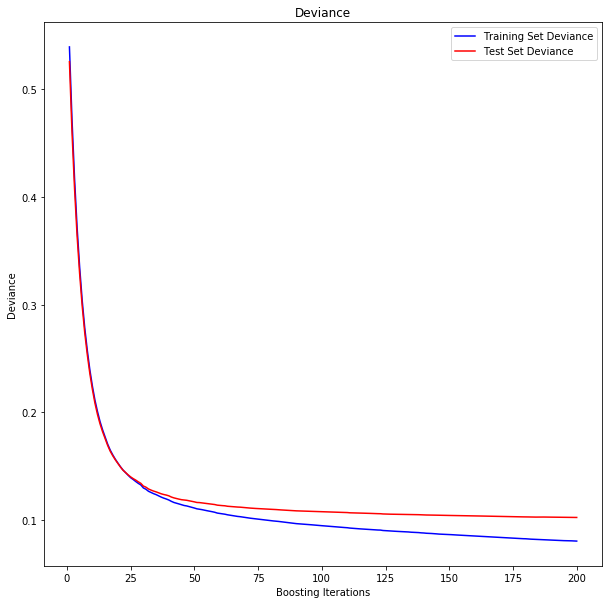

In [63]:
deviance_plot(grad_4)

In [64]:
def top_20_features_2(grad):
    feature_importance = grad.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    name=list(X.columns)
    grad_pairs=dict(zip(name,feature_importance))
    grad_pairs=pd.DataFrame.from_dict({k: v for k, v in sorted(grad_pairs.items(), key=lambda item: item[1])},orient='index')
    grad_top=grad_pairs.tail(20)
    
    plt.figure(figsize=(10,10))
    plt.barh(list(grad_top.index),grad_top.iloc[:,0], align='center')
    plt.ylabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

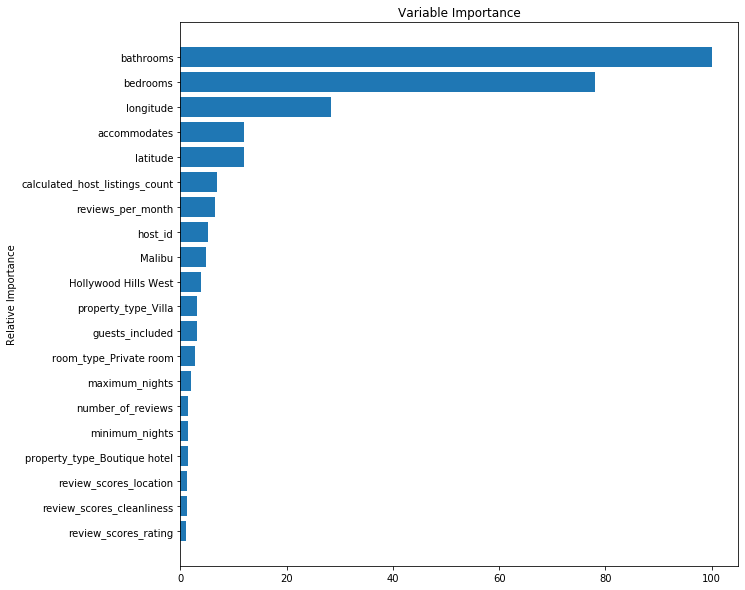

In [65]:
top_20_features_2(grad_1)

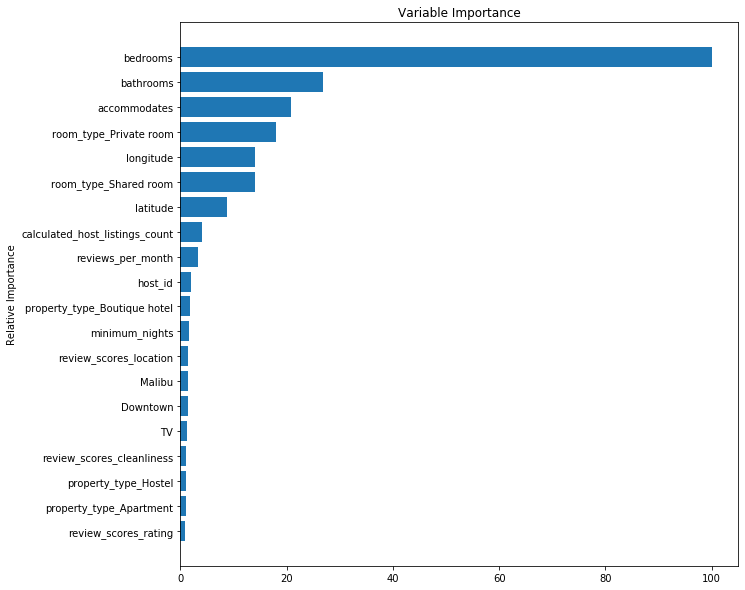

In [66]:
top_20_features_2(grad_2)

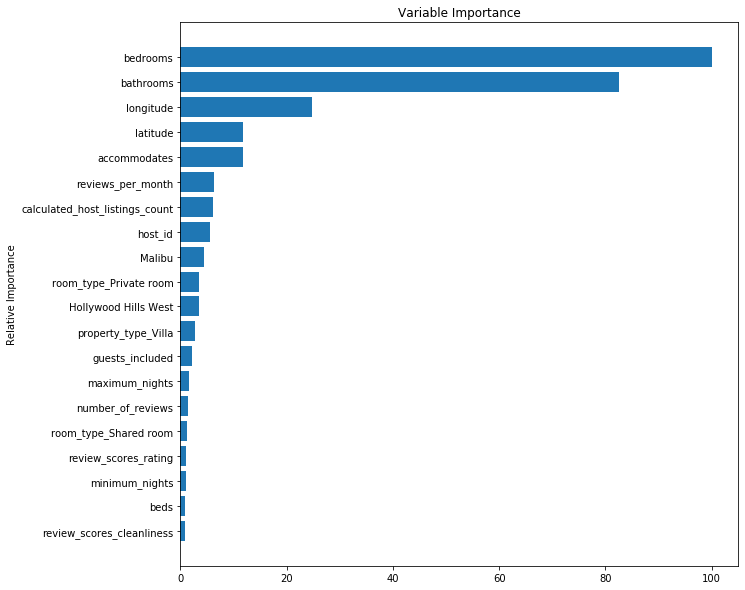

In [67]:
top_20_features_2(grad_3)

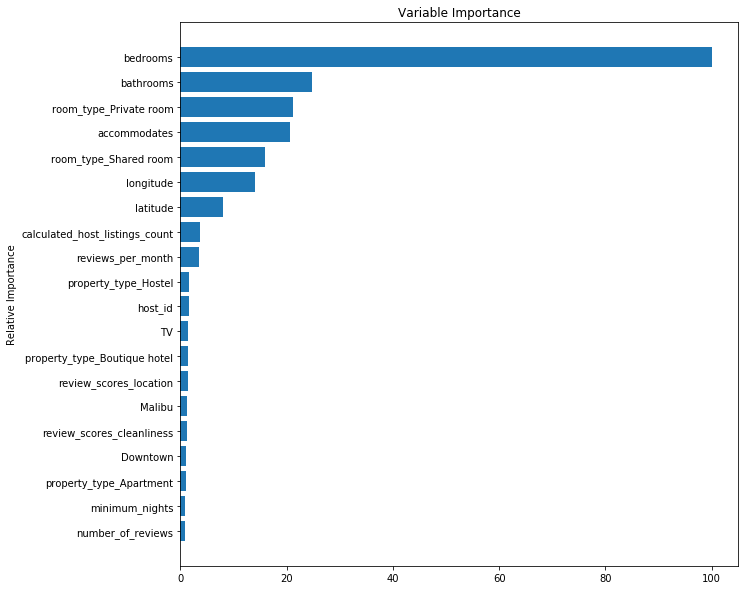

In [68]:
top_20_features_2(grad_4)

In [ ]:
#try xgboost

In [69]:
xg=xgb.XGBRegressor()
X_train, X_test, y_train, y_test = train_test_split(X,y_3_log,test_size=0.3,random_state=42)
xg.fit(X_train, y_train)
xg_r2 = grad_4.score(X_test,y_test)
print(xg_r2)

[09:38:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8307478119123485


## Overpriced and Underpriced Listings vs. Availability

In [107]:
import statsmodels.api as sm
from scipy import stats
from scipy.stats import t
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [108]:
y_3_log_predicted=grad_4.predict(X)

In [111]:
df = pd.DataFrame(list(zip(y_3_log_predicted, y_3_log,list(l_201912.availability_30))), 
               columns =['predicted_log_price', 'actual_log_price','availability'])

In [112]:
df.head()

,predicted_log_price,actual_log_price,availability
0,6.789329,6.406880,0
1,6.535249,6.403574,0
2,5.573205,5.780744,12
3,5.701073,6.253829,9
4,5.853601,5.752573,0


In [113]:
df['log_price_diff']=df.actual_log_price-df.predicted_log_price

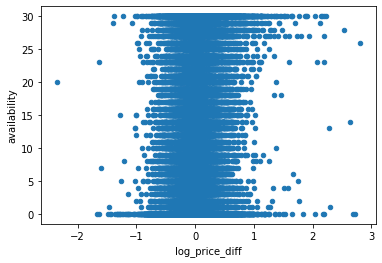

In [114]:
df.plot.scatter('log_price_diff','availability')

In [153]:
#df['availability_bucket']=df['availability_bucket'].astype('category')
#df=pd.get_dummies(df,drop_first=True)

In [207]:
#df.head()

In [116]:
X=np.array(df['log_price_diff']).reshape(-1,1)
y=df['availability']
X = sm.add_constant(X)

In [117]:
lm=sm.OLS(y,X)
result=lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           availability   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     827.7
Date:                Fri, 13 Mar 2020   Prob (F-statistic):          7.68e-180
Time:                        18:48:55   Log-Likelihood:            -1.2856e+05
No. Observations:               33701   AIC:                         2.571e+05
Df Residuals:                   33699   BIC:                         2.571e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.2226      0.060    187.692      0.000      11.105      11.340
x1             5.8300      0.203     28.770      0.000       5.433       6.227
==============================================================================
Omnibus:                    26473.608   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3351.358
Skew:                           0.498   Prob(JB):                         0.00
Kurtosis:                       1.819   Cond. No.                         3.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#From listing data as of 2019-12, the underpriced listings have less availability, while the overpriced listings have
#more availability.

## Overlay Models and Apply Predictions to Other Months

In [70]:
#Nov 2019
def process(l,month_avg,dec_avg):
    
    #filename=input(l)
    #l=pd.read_csv('/Users/ruoqigao/Desktop/Springboard/capstone 1 data/'+ filename + '.csv')
    l['avail_30_bucket']=[0 if n in np.arange(0,6) else 1 if n in np.arange(6,25) else 2 for 
                             n in l['availability_30']]
    rm_list=['Year','Month','has_availability','availability_30', 'availability_365','availability_60', 
             'availability_90','price','cleaning_fee','extra_people','id','host_since','neighbourhood_cleansed',
             'avail_30_bucket']
    col_list=list(l.columns.values)
    x_list = [e for e in col_list if e not in rm_list]
    X=l[x_list]
    y=l['price']
    y=y*month_avg*dec_avg
    y_log=np.log(y)
    y_3=l['price']*3+l['cleaning_fee']
    y_3_log=np.log(y_3)
    object_cols=['bed_type','host_identity_verified','host_info','host_is_superhost',
                 'instant_bookable','is_business_travel_ready','is_location_exact','property_type',
                 'require_guest_phone_verification','require_guest_profile_picture','room_type']
    X[object_cols]=X[object_cols].apply(lambda x: x.astype('category'),axis=0)
    X=pd.get_dummies(X,drop_first=True)
    
    return X, y_3_log

In [71]:
l_201911=pd.read_csv('/Users/ruoqigao/Desktop/Springboard/capstone 1 data/l_201911.csv')
X_11,y_3_log=process(l_201911,173.778605,173.755496)

In [72]:
X_11.shape

(36074, 196)

In [75]:
y_3_log.shape

(36074,)

In [76]:
y_3_log_predicted=grad_4.predict(X)

In [77]:
grad_4.score(X_11,y_3_log)

0.7913556869460422

In [118]:
df = pd.DataFrame(list(zip(y_3_log_predicted, y_3_log,list(l_201911.availability_30))), 
               columns =['predicted_log_price', 'actual_log_price','availability'])
df['log_price_diff']=df.actual_log_price-df.predicted_log_price
X=np.array(df['log_price_diff']).reshape(-1,1)
y=df['availability']
X = sm.add_constant(X)
lm=sm.OLS(y,X)
result=lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           availability   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 0.0003163
Date:                Fri, 13 Mar 2020   Prob (F-statistic):              0.986
Time:                        18:49:33   Log-Likelihood:            -1.2890e+05
No. Observations:               33701   AIC:                         2.578e+05
Df Residuals:                   33699   BIC:                         2.578e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3395      0.060    187.728      0.000      11.221      11.458
x1            -0.0036      0.205     -0.018      0.986      -0.405       0.398
==============================================================================
Omnibus:                   529458.055   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3535.499
Skew:                           0.411   Prob(JB):                         0.00
Kurtosis:                       1.642   Cond. No.                         3.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""